In [32]:
from bs4 import BeautifulSoup
import requests
import re
import pprint
import wordfreq
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
import random
import datetime
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

These functions are meant to extract presidential speeches from the site millercenter.org.  get_president(N) finds the Nth president and returns a "speeches" variable that is a list containing the text of each speech by that president.  The president's number is 0-indexed, so George Washington is president number 0, while Donald Trump is president number 43.  Grover Cleveland is only counted once, as president number 21, although he was elected twice to nonconsecutive term.  This convention is followed throughout.

In [33]:
# The 0th president (Washington) is actually numbered 44 on millercenter.org.  Thus, we have to convert
# the president's number 0 through 43 into a number suitable for millercenter.org.  Trump is, randomly enough
# president number 8396.
# The 21st and 23rd president would ordinarily both be Cleveland, but Cleveland is only counted once.
# #23 is considered to be Harrison; that means there are only 44 presidents
def pres_numbers_list():
    return [44, 45] + [3, 4] + [141] + list(range(6, 44)) + [8396]

def get_pres_name(N):
    return ["George Washington", "John Adams", "Thomas Jefferson", "James Madison", "James Monroe", "John Quincy Adams",\
           "Andrew Jackson", "Martin van Buren", "William Harrison", "John Tyler", "James K. Polk", "Zachary Taylor",\
           "Millard Fillmore", "Franklin Pierce", "James Buchanan", "Abraham Lincoln", "Andrew Johnson",\
           "Ulysses S. Grant", "Rutherford B. Hayes", "James A. Garfield", "Chester A. Arthur", "Grover Cleveland",\
           "Benjamin Harrison", "William McKinley", "Theodore Roosevelt", "William Taft", "Woodrow Wilson",\
           "Warren G. Harding", "Calvin Coolidge", "Herbert Hoover", "Franklin D. Roosevelt", "Harry S. Truman",\
           "Dwight D. Eisenhower", "John F. Kennedy", "Lyndon B. Johnson", "Richard Nixon", "Gerald Ford",\
           "Jimmy Carter", "Ronald Reagan", "George H. W. Bush", "Bill Clinton", "George W. Bush", "Barack Obama",\
           "Donald Trump"][N]

def get_president(N):
    if N < 0 or N > 43:
        print("Error: no president", N)
        return list()
    N = pres_numbers_list()[N]
    millerpage = f"https://millercenter.org/the-presidency/presidential-speeches?field_president_target_id[{N}]={N}"
    page = requests.get(millerpage)
    soup = BeautifulSoup(page.content, 'html.parser')
    #dummy = 'a href="/the-presidency/presidential-speeches'
    speechlist = soup.find_all(href=re.compile('/the-presidency/presidential-speeches/'))
    URLlist = ["https://millercenter.org" + x['href'] for x in speechlist]
    #pprint.pprint(URLlist)
    speeches = list()
    n = -1
    for URL in URLlist:
        n = n + 1
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        for e in soup.find_all('br'):
            e.replace_with('\n')
        x = soup('h3', text="Transcript")
        listofps = x[0].parent.findChildren('p')
        #print([type(p.contents[0]) for p in listofps])
        #string = string.replace(u'\xa0', u' ')
        # print([p.contents[0].name for p in listofps])
        textofspeech = " ".join([" ".join([c for c in p.contents if not c.name]) for p in listofps])
        # Replace funny single quote #8217 with single quote #39
        textofspeech = textofspeech.replace('\’', "'")
        textofspeech = textofspeech.replace("\'", "'")
        speeches.append(textofspeech)
    return speeches

def count_speeches():
    num_speeches = 0
    for N in range(0, 44):
        num_speeches += len(get_president(N))
        print(N, num_speeches)
    print("Total:", num_speeches)
    print(num_speeches/44)

get_overrep_words takes a list of the text of each speech, and returns a dictionary of potentially "overrepresented words" the form:

d[word] = weight

The "weight" for each word measures, in part, how "overrepresented" each word is in the speech corpus of a given president.

This weight is calculated as follows.  The goal is to have a weight that reflects (1) the word's frequency in the English language compared with other words that have a similar frequency in the corpus, (2) the overall frequency of the word in the speech corpus.  Thus, a word that is highly unusual ("supercalifragilisticexpealidocious") but only appears twice in the speech corpus is only of moderate interest; likewise, a word that is very common, but appears only the usual amount in the corpus ("the") is also only of moderate interest.  The weight for each word is computed as a sum of logs of these two factors.

Getting into the details: To compute the weight, the incidence count of the word is first tallied in the combined speeches of a president.

Using the wordfreq library, each word's frequency in English is obtained (actually the log of the frequency), so that it can be compared with the log of the frequency in the speeches.

Using the statsmodels library, a least squares regression is used to find the linear relationship between these two logs.

This linear relationship can then be used to compute the predicted English frequency for a word that has the given corpus frequency.  This predicted English frequency can be compared to the word's actual English frequency.  The difference between predicted and actual (using subtraction of the logs) is essentially the desired meatric.  A weight value of 1 would mean that the word is "e" times less common in English than other words of a similar corpus frequency.

Next, the number of words in each set of speeches can range from 20,000 to 800,000, so the number of appearances is multiplied by (800,000 / length) to get the number that would appear in 800,000.  Then, the log is taken.  This number is added to the weight to get the final weight value.  This takes into account that we care more about words that appear many times as opposed to only once.

In [34]:
def get_overrep_words(speeches, makeplot = False):
    speeches_combined = " ".join(speeches)
    wordlist = wordfreq.tokenize(speeches_combined, 'en')
    length = len(wordlist)
    print("Length of speeches:", length)
    freqlist = [(x, wordlist.count(x)) for x in set(wordlist)]
    freqlist.sort(key = lambda x: x[1])
    freqmap = [(np.log(wordfreq.word_frequency(x[0], 'en')), np.log(x[1] / length)) for x in freqlist]
    xy = list(zip(*freqmap))
    #plt.figure()
    #plt.plot(*xy, 'b.')
    dfxy = pd.DataFrame(xy).T
    dfxy.columns = ['logen', 'logcorpus']
    dfxy = dfxy.replace([np.inf, -np.inf], np.nan).dropna()
    #print(dfxy)
    if makeplot:
        ax = dfxy.plot(x='logcorpus', y='logen', title = 'log-log plot to predict English frequency', style='b.')
        plt.xlabel('log of corpus frequency')
        plt.ylabel('log of English frequency')
        
    model = sm.OLS.from_formula('logen ~ logcorpus', dfxy) 
    regr = model.fit()
    #regr.summary()
    
    if makeplot:
        # Plot linear fit
        p = regr.params
        x0 = -12
        x1 = -1
        x = np.arange(0, 2) * (x1 - x0) + x0
        ax.plot(x, p.Intercept + p.logcorpus * x, 'k-')
        plt.gcf().savefig("logen_plot.png")

    # Replace funny single quote #8217 with single quote #39
    freqlist = [(x[0].replace('’', "'"), x[1]) for x in freqlist]
    
    # An item in this list is: (word, weight, corpus frequency)
    weightlist = [(x[0], (regr.predict(pd.Series([np.log(x[1] / length)], name='logcorpus')).iloc[0] - \
            np.log(wordfreq.word_frequency(x[0], 'en'))) + np.log(x[1] * 140000 / length), \
            np.log(x[1] / length)
            ) for x in freqlist if ((x[1] * 140000 / length > 1) and x[0] != 'applause' and x[0] != 'laughter' and x[0] != 'booo')]
    
    if makeplot:
        plt.figure()
        plt.plot([x[2] for x in weightlist], [x[1] for x in weightlist], 'k.')
        plt.title('weight vs. log corpus frequency')
        plt.xlabel('log of corpus frequency')
        plt.ylabel('assigned weight')
        plt.gcf().savefig("weight_plot.png")
        
    return {x[0]: x[1] for x in weightlist if (x[1] > 1 and not np.isinf(x[1]))}

In [28]:
print(get_pres_name(24))
_ = get_overrep_words(get_president(24), makeplot = False)

Theodore Roosevelt
Length of speeches: 137013


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


James K. Polk
Length of speeches: 54804


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


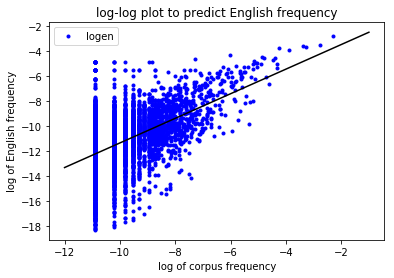

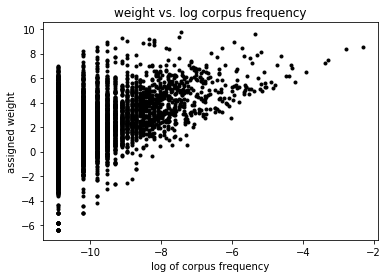

In [31]:
print(get_pres_name(10))
_ = get_overrep_words(get_president(10), makeplot = True)

In [35]:
def make_two_speech_lists(speeches):
    lst1 = np.random.choice(speeches, size=int(len(speeches)/2), replace=False)
    lst2 = [x for x in speeches if not (x in lst1)]
    return (lst1, lst2)

get_paired_words returns a list of the form:

[(word1, sim1), (word2, sim2), ...]

Where the similarity score (sim1) for word 1 is the minimum of the word's weight for president M and for president N.  Only words that appear in both president M and president N's speeches will get a score.

get_similarity finds the total similarity score by adding them up.

The result is a similarity score that compares the two presidents.  If the presidents share more words in common (and with higher weights), then their similarity score will tend to be higher.

In [36]:
def get_paired_words(overrep_words, M, N):
    if M < 0 or M >= len(overrep_words) or N < 0 or N >= len(overrep_words):
        print("M or N is out of bounds in get_paired_words.")
        return list()
    paired_words = list()
    for x in overrep_words[M]:
        if x in overrep_words[N]:
            paired_words.append((x, min(overrep_words[M][x],overrep_words[N][x])))
    return paired_words

def get_similarity(overrep_words, M, N):
    pw = get_paired_words(overrep_words, M, N)
    total = sum(x[1] for x in pw if x[1] > 0)
    return total

This code loops through a range of presidents, getting a list of overrepresented words (with their weights) for each.

In [37]:
NUMP = 44

holdout = True

random.seed(datetime.datetime.now())

def generate_overrep_words(NUMP):

    overrep_words = list()
    overrep_words_test = list()

    for N in range(44 - NUMP, 44):
        print(get_pres_name(N))
        speeches = get_president(N)
        sp_train, sp_test = make_two_speech_lists(speeches)
        if holdout:
            if len(sp_train) == 0:
                sp_train = sp_test.copy()
                print("Only one (testing) speech for president ", N)
            if len(sp_test) == 0:
                sp_test = sp_train.copy()
                print("Only one (training) speech for president ", N)
            ov = get_overrep_words(sp_train)
            ov_test = get_overrep_words(sp_test)
            overrep_words.append(ov)
            overrep_words_test.append(ov_test)
        else:
            ov = get_overrep_words(speeches)
            overrep_words.append(ov)
            
    return overrep_words, overrep_words_test
    
overrep_words, overrep_words_test = generate_overrep_words(NUMP)

George Washington
Length of speeches: 14461


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


Length of speeches: 6573
John Adams
Length of speeches: 7223
Length of speeches: 7467
Thomas Jefferson
Length of speeches: 9301
Length of speeches: 10110
James Madison
Length of speeches: 11378
Length of speeches: 11489
James Monroe
Length of speeches: 24429
Length of speeches: 25774
John Quincy Adams
Length of speeches: 19986
Length of speeches: 17056
Andrew Jackson
Length of speeches: 32792
Length of speeches: 53263
Martin van Buren
Length of speeches: 26927
Length of speeches: 38011
William Harrison
Only one (testing) speech for president  8
Length of speeches: 8459
Length of speeches: 8459
John Tyler
Length of speeches: 24804
Length of speeches: 21698
James K. Polk
Length of speeches: 29075
Length of speeches: 25729
Zachary Taylor
Length of speeches: 2077
Length of speeches: 9318
Millard Fillmore
Length of speeches: 9277
Length of speeches: 29757
Franklin Pierce
Length of speeches: 27748
Length of speeches: 22769
James Buchanan
Length of speeches: 38361
Length of speeches: 26529
Ab

Create a similarity matrix such that X[i,j] is the similarity of presidents i and j.  Then use SpectralClustering to perform the clustering.  A silhouette score is computed.

In [38]:
def similarity_matrix(overrep_words):
    X = np.zeros((NUMP, NUMP))
    for i in range(0, NUMP):
        for j in range(0, i):
            X[i,j] = get_similarity(overrep_words, i, j)
            X[j,i] = X[i,j]
    return X

def spectral_cluster(overrep_words, overrep_words_test, n_clusters, holdout = True):
    
    X = similarity_matrix(overrep_words)
    clustering = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", assign_labels="discretize").fit(X)

    if holdout:
        X_test = similarity_matrix(overrep_words_test)
        clustering_test = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", assign_labels="discretize").fit(X_test)
        coeff = 0.5*(np.std(X) + np.std(X_test))
    else:
        coeff = np.std(X)

    if holdout:
        sil = 0.5*(silhouette_score(np.exp(-X/coeff) - np.eye(len(overrep_words)), clustering.labels_, metric="precomputed") \
                   + silhouette_score(np.exp(-X_test/coeff) - np.eye(len(overrep_words)), clustering_test.labels_, metric="precomputed"))
    else:
        sil = silhouette_score(np.exp(-X_avg/coeff) - np.eye(len(overrep_words)), clustering.labels_, metric="precomputed")
       
    return clustering.labels_, clustering_test.labels_, sil

Find the silhouette coefficient for each number of clusters.

In [39]:
for n_clusters in range(2, 8):
    sil_total = 0
    num_iter = 4
    for i in range(0, num_iter):
        lab1, lab2, sil = spectral_cluster(overrep_words, overrep_words_test, n_clusters, holdout = True)
        sil_total += sil
    print(f"For {n_clusters} clusters, silhouette coefficient is {sil_total/num_iter}")

For 2 clusters, silhouette coefficient is 0.5383400569918411
For 3 clusters, silhouette coefficient is 0.19575429668877892
For 4 clusters, silhouette coefficient is 0.10403277417843429
For 5 clusters, silhouette coefficient is 0.0669981254432348
For 6 clusters, silhouette coefficient is 0.0848467639902841
For 7 clusters, silhouette coefficient is 0.0759477799023491


Find the cluster labels for the two sets of data using 3 clusters.

In [40]:
lab1, lab2, sil = spectral_cluster(overrep_words, overrep_words_test, 3, holdout = True)
print(lab1)
print(lab2)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 0 0 0 0 0 0 2 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]


compute_cluster_overlap will compute the overlap between the training and testing data.  The overlap is defined by assuming that each cluster in the training data corresponds to the cluster(s) in the testing data with the best fit (the maximum overlap.)  Then, the number of presidents whose training cluster matches their testing cluster is counted.

In [41]:
def compute_cluster_overlap(labels1, labels2):
    if len(labels1) != len(labels2):
        print("Error in compute_cluster_overlap: labels1, labels2 not same length.")
        return
    corresp = dict()
    for lab1 in set(labels1):
        ct = dict()
        for lab2 in set(labels2):
            for i in range(len(labels1)):
                ct.setdefault(lab2, 0)
                if labels1[i] == lab1 and labels2[i] == lab2:
                    ct[lab2] += 1
        ctreverse={v:k for k,v in ct.items()}
        corresp[lab1] = ctreverse[max(ctreverse)]
    total = 0
    for i in range(len(labels1)):
        if labels2[i] == corresp[labels1[i]]:
            total += 1
    print("Correspondence (training cluster: testing cluster):", corresp)
    print("Overlap ratio:", total, "out of", len(labels1))        
    return total, len(labels1)

compute_cluster_overlap(lab1, lab2)

Correspondence (training cluster: testing cluster): {0: 0, 1: 1, 2: 2}
Overlap ratio: 40 out of 44


(40, 44)

These functions make use of only the "training" data due to the holdout (or all of the data, if you have set holdout = False).

get_inlist will make a list of the numbers of the president that belong to the ith cluster in the training set (zero indexed this time.)

get_characteristic_words accepts as an argument a list of president numbers (zero indexed.)  Thus, a list [0, 2, 3] will combine the 0th, 2nd, and 3rd presidents into a group, which is then compared with all presidents not in the list.  You can use get_inlist to generate this list from a cluster number, or you can pick a single president with a single element list like [2].

The function finds the median weight in the "inlist" and the median weight in the "outlist," subtracting the two to find the score for each word.  In the resulting list, a positive score indicates that a word has a high weight in the inlist, while a negative score indicates that it has a high weight in the outlist.  If there are an odd number of presidents in the list, the median takes the lower of the two middle numbers.

Thus, to find the most characteristic words in the inlist, go to the end of the output and look at the words with the highest score

In [42]:
import statistics

def medlow(lst):
    sortlst = sorted(lst)
    if len(sortlst) % 2 == 0:
        return(sortlst[int(len(sortlst) / 2) - 1])
    else:
        return(sortlst[int(len(sortlst) / 2 - 0.5)])

def get_inlist(lab, i):
    return [j for j in range(0, len(lab)) if lab[j] == i]
    
def get_characteristic_words(overrep_words, inlist):
    wordscore_in = dict()
    wordscore_out = dict()
    for k in range(0, len(overrep_words)):
        if k in inlist:
            for word, score in overrep_words[k].items():
                wordscore_in.setdefault(word, list())
                wordscore_in[word].append(score)
        else:
            for word, score in overrep_words[k].items():
                wordscore_out.setdefault(word, list())
                wordscore_out[word].append(score)
    for word in wordscore_in.keys():
        for i in range(0, len(inlist) - len(wordscore_in[word])):
            wordscore_in[word].append(0)
    for word in wordscore_out.keys():
        for i in range(0, (len(overrep_words) - len(inlist)) - len(wordscore_out[word])):
            wordscore_out[word].append(0)
    scorelist = list()
    for word in wordscore_in.keys():
        med_in = medlow(wordscore_in[word]) if word in wordscore_in.keys() else 0
        med_out = medlow(wordscore_out[word]) if word in wordscore_out.keys() else 0
        scorelist.append((word, med_in - med_out))
    return sorted(scorelist, key = lambda x: x[1])

print([x[0] for x in get_characteristic_words(overrep_words, get_inlist(lab1, 0))[-50:]])

['guaranty', 'amounted', 'disposition', 'ascertaining', 'intercourse', 'reduction', 'speedily', 'bill', 'authorized', 'beneficent', 'deem', 'postal', 'bonds', 'surplus', 'refunding', 'recommendation', 'exactions', 'proclamation', 'earnest', 'treasury', 'tariff', 'enactment', 'arbitration', 'practicable', 'fiscal', 'justly', 'cent', 'evils', 'furnish', 'expended', 'commissioners', 'commission', 'gratifying', 'legation', 'discriminations', 'receipts', 'pursuance', 'appropriation', 'pending', 'commend', 'hereunto', 'satisfactory', 'liberality', 'postmaster', 'earnestly', 'appropriations', 'unexpended', 'heretofore', 'intrusted', 'herewith']


In [43]:
print([x[0] for x in get_characteristic_words(overrep_words, get_inlist(lab1, 1))[-50:]])

['million', 'freedom', 'better', 'achieve', 'come', 'pledge', 'truman', 'working', 'your', 'decisions', 'effort', 'proud', 'strong', 'want', 'program', 'about', 'asia', 'bipartisan', 'work', 'we', 'help', 'vital', 'cannot', 'let', 'commitment', 'know', 'say', 'ago', 'because', 'weapons', 'economic', 'nuclear', 'leaders', 'world', 'here', 'strengthen', 'forces', 'today', 'jobs', 'tax', 'tonight', 'soviet', 'billion', 'aggression', 'america', 'you', 'allies', "nation's", 'americans', "america's"]


In [44]:
print([x[0] for x in get_characteristic_words(overrep_words, get_inlist(lab1, 2))[-50:]])

['communicated', 'objects', 'forbearance', 'authorized', 'britain', 'republics', 'condition', 'furnish', 'deemed', 'commencement', 'guaranty', 'legislature', 'render', 'indispensable', 'execution', 'expediency', 'labors', 'enlightened', 'portion', 'favorable', 'earnestly', 'disposition', 'peculiar', 'hitherto', 'practicable', 'satisfactory', 'amity', 'entertained', 'object', 'revenue', 'receipts', 'speedily', 'justly', 'expedient', 'territories', 'continuance', 'ratifications', 'exigencies', 'propriety', 'vessels', 'effectual', 'expenditures', 'plenipotentiary', 'appropriations', 'herewith', 'intercourse', 'treasury', 'effectually', 'heretofore', 'intrusted']


In [45]:
print([x[0] for x in get_characteristic_words(overrep_words, [43])[-50:]]) # Trump

["heaven's", "cj's", 'celestino', 'cuevas', 'disrupters', 'melania', "america's", "we've", 'energy', 'hardworking', 'complacent', 'going', 'tax', 'clobbered', 'thank', 'parkland', 'incredible', 'stoneman', 'tenderhearted', 'marjory', 'gorsuch', 'goodlatte', 'autoworkers', 'renegotiating', 'scout', 'cuts', 'levitt', 'tillerson', '2,000k', 'businessperson', 'congresswomen', 'ashlee', 'sempra', "scouting's", 'tremendous', 'leppert', "we're", "otto's", 'levittown', 'jamboree', 'kenton', 'seong', 'staub', 'cpac', 'schwab', 'mickens', 'daca', 'scouts', 'trump', 'zinke']


In [46]:
print([x[0] for x in get_characteristic_words(overrep_words, [42])[-50:]]) # Obama

['hymnals', 'weapons', 'tolerably', 'reverend', 'workers', 'wage', 'lowcountry', 'immigrants', 'cynics', 'jobs', 'deporting', 'families', "that's", 'impugning', 'pinpricks', 'zika', 'poverty', 'dealbreaker', 'bipartisan', 'mobility', 'crankiness', 'moyers', 'begrudged', "america's", 'unhealed', 'zigs', 'antidiscrimination', 'rutgers', 'rancor', 'astrid', 'guadagno', 'burnell', 'retrain', 'americans', 'isil', 'clem', "we've", 'undocumented', 'hardworking', 'wahler', 'grace', 'barchi', 'neera', 'edisons', 'assad', 'likelier', 'strivers', "assad's", 'inequality', 'pinckney']
